In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import glob, os, warnings
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.integrate import trapz, cumtrapz
from scipy.optimize import minimize
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.linear_model import LinearRegression

In [29]:
def load_rto_data(data_path, clean_data = True, return_O2_con_in = False):

    df = pd.read_excel(data_path + '.xls')
    
    # Read in data
    Time = df.Time.values/60
    O2 = df.O2.values
    CO2 = df.CO2.values
    Temp = df.Temperature.values
    
    ind100C = np.amin(np.asarray(Temp > 100).nonzero())
    ind120C = np.amin(np.asarray(Temp > 120).nonzero())
    inds750 = np.asarray(Temp > 745).nonzero()[0]
    ind750C1 = inds750[np.round(0.75*inds750.shape[0]).astype(int)]
    ind750C2 = inds750[np.round(0.9*inds750.shape[0]).astype(int)]

    # Gather datapoints and perform linear regression correction
    correction_times = np.concatenate([Time[ind100C:ind120C+1], Time[ind750C1:ind750C2+1]])
    correction_O2s = np.concatenate([O2[ind100C:ind120C+1], O2[ind750C1:ind750C2+1]])
    slope, intercept, _, _, _ = linregress(correction_times, correction_O2s)
    O2_baseline = slope*Time + intercept
    O2_con_in = intercept

    # Calculate %O2 consumption and conversion
    O2_consumption = np.maximum(O2_baseline - O2, 0)
    
    start_ind_max, end_ind_max_O2 = find_start_end(O2_consumption)
    O2_consumption[:start_ind_max] = 0
    O2_consumption[end_ind_max_O2:] = 0
    
    # Process CO2 data
    correction_CO2s = np.concatenate([CO2[ind100C:ind120C+1], CO2[ind750C1:ind750C2+1]])
    slope, intercept, _, _, _ = linregress(correction_times, correction_CO2s)
    CO2_baseline = slope*Time + intercept
    CO2_production = np.maximum(CO2 - CO2_baseline, 0)
    
    start_ind_max, end_ind_max_CO2 = find_start_end(CO2_production)
    CO2_production[:start_ind_max] = 0
    CO2_production[end_ind_max_CO2:] = 0 
    
    # Preliminary correction
    global_max_ind = max(end_ind_max_O2, end_ind_max_CO2)
    Time = Time[:global_max_ind]
    Temp = Temp[:global_max_ind]
    O2_consumption = O2_consumption[:global_max_ind]
    CO2_production = CO2_production[:global_max_ind]
    
    ydict = {'Time': Time, 'Temp': Temp, 'O2_consumption': O2_consumption, 'O2_con_in': O2_con_in, 
             'CO2_production': CO2_production}
    
    return ydict
    

def find_start_end(x):
    '''
    Find start and end time stamps from array x
    
    '''
    
    start_ind = 0
    end_ind = 0
    start_ind_max = 0
    end_ind_max = x.shape[0]
    cumsum = 0.0
    max_cumsum = 0.0
    for i in range(x.shape[0]):
        if x[i] <= 0:
            if cumsum > max_cumsum:
                max_cumsum = cumsum
                start_ind_max = start_ind
                end_ind_max = end_ind
            
            cumsum = 0.0
            start_ind = i
            end_ind = i
                
        else:
            cumsum += x[i]
            end_ind += 1
    
    return start_ind_max, end_ind_max

In [30]:
class RtoData:

    def __init__(self, dataset_name):
        self.dataset_dir = os.path.join('datasets', 'RTO', dataset_name)
        self.data_load()


    def data_load(self):
        '''
        Parse the input data file for experimental data kinetic cell models

        '''

        self.Oil_con_init = 0.04

        self.heating_rates = [float(name[:-9]) for name in os.listdir(self.dataset_dir) if name[-9:].lower()=='c_min.xls']

        # Begin loading data
        self.heating_data = {}
        INTERPNUM = 300
        
        for hr in self.heating_rates:
            print('Loading heating rate {}...'.format(hr))
            # Read RTO data
            ydict = load_rto_data(os.path.join(self.dataset_dir, str(hr)+'C_min'))
            
            # Downsample and append
            time_downsampled = np.linspace(ydict['Time'].min(), ydict['Time'].max(), num=INTERPNUM)
            Temp_ds = np.interp(time_downsampled, ydict['Time'], ydict['Temp'])
            O2_consumption_ds = np.interp(time_downsampled, ydict['Time'], ydict['O2_consumption']/100)
            CO2_production_ds = np.interp(time_downsampled, ydict['Time'], ydict['CO2_production']/100)
            
            O2_conversion = cumtrapz(O2_consumption_ds,x=time_downsampled, initial=0.0)/trapz(O2_consumption_ds, x=time_downsampled)
            CO2_conversion = cumtrapz(CO2_production_ds,x=time_downsampled, initial=0.0)/trapz(CO2_production_ds, x=time_downsampled)

            self.heating_data[hr] = {'Time': time_downsampled, 'Temp': Temp_ds, 'O2': O2_consumption_ds, 
                                     'CO2': CO2_production_ds, 'O2_con_in': ydict['O2_con_in']/100,
                                     'O2_conversion': O2_conversion, 'CO2_conversion': CO2_conversion}
    
    
    def print_consumption_curves(self, save_path = None):

        plt.figure()
        for hr in sorted(self.heating_data.keys()):
            hr_dict = self.heating_data[hr]
            plt.plot(hr_dict['Time'], 100*hr_dict['O2'])
        plt.xlabel('Time [min]')
        plt.ylabel('O2 consumption [% mol]')
        plt.title('O2 consumption for experiments')
        plt.legend([str(hr) for hr in sorted(self.heating_data.keys())])

        if isinstance(save_path, str):
            plt.savefig(save_path[:-4] + '_O2consumption' + save_path[-4:])
        else:
            plt.show()
            
        plt.figure()
        for hr in sorted(self.heating_data.keys()):
            hr_dict = self.heating_data[hr]
            plt.plot(hr_dict['Time'], 100*hr_dict['CO2'])
        plt.xlabel('Time [min]')
        plt.ylabel('CO2 production [% mol]')
        plt.title('CO2 production for experiments')
        plt.legend([str(hr) for hr in sorted(self.heating_data.keys())])

        if isinstance(save_path, str):
            plt.savefig(save_path[:-4] + '_CO2production' + save_path[-4:])
        else:
            plt.show()

        plt.figure()
        for hr in sorted(self.heating_data.keys()):
            hr_dict = self.heating_data[hr]
            plt.plot(hr_dict['Time'],hr_dict['Temp'])
        plt.xlabel('Time [min]')
        plt.ylabel('Temperature [C]')
        plt.title('Temperature profiles for experiments')
        plt.legend([str(hr) for hr in sorted(self.heating_data.keys())])

        if isinstance(save_path, str):
            plt.savefig(save_path[:-4] + '_temperature' + save_path[-4:])
        else:
            plt.show()
            
            
    def print_conversion_curves(self):
        
        # Print O2 conversion vs CO2 conversion
        plt.figure()
        for hr in sorted(self.heating_data.keys()):
            hr_dict = self.heating_data[hr]
            plt.plot(hr_dict['Time'], hr_dict['O2_conversion'])
        plt.xlabel('Time [min]')
        plt.ylabel('O2 converison [% mol]')
        plt.title('O2 conversion for experiments')
        plt.legend([str(hr) for hr in sorted(self.heating_data.keys())])
        plt.show()

        plt.figure()
        for hr in sorted(self.heating_data.keys()):
            hr_dict = self.heating_data[hr]
            plt.plot(hr_dict['Time'], hr_dict['CO2_conversion'])
        plt.xlabel('Time [min]')
        plt.ylabel('CO2 converison [% mol]')
        plt.title('CO2 conversion for experiments')
        plt.legend([str(hr) for hr in sorted(self.heating_data.keys())])
        plt.show()

        plt.figure()
        for hr in sorted(self.heating_data.keys()):
            hr_dict = self.heating_data[hr]
            plt.plot(hr_dict['O2_conversion'], hr_dict['CO2_conversion'])
        plt.xlabel('O2 conversion [% mol]')
        plt.ylabel('CO2 converison [% mol]')
        plt.title('Comparison of conversion for experiments')
        plt.legend([str(hr) for hr in sorted(self.heating_data.keys())])
        plt.show()
        
    
    def isoconversional_analysis(self, corrected=False):
        '''
        Use Friedman method for now
        
        '''
        R = 8.3145
        if corrected:
            maxes = []
            for hr in sorted(self.heating_rates):
                max_ind = np.argmax(self.heating_data[hr]['O2'])
                maxes.append(self.heating_data[hr]['O2_conversion'][max_ind])
            max_conv = np.mean(maxes)
        else:
            max_conv = 0.99
            
        conv_grid = np.linspace(0.01,max_conv,200)
        
        O2_eact, O2_rorder, O2_preexp = [], [], []
#         CO2_eact = []
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            
            for i in range(conv_grid.shape[0]):
                model = LinearRegression()
                conv = conv_grid[i]
                O2_temps = [np.interp(conv, self.heating_data[hr]['O2_conversion'], -1/self.heating_data[hr]['Temp']/R) for hr in self.heating_rates]
                dO2_convs = [np.interp(conv, self.heating_data[hr]['O2_conversion'],np.log(self.heating_data[hr]['O2'])) for hr in self.heating_rates]
                model.fit(np.column_stack((O2_temps, np.log(conv)*np.ones_like(O2_temps))), dO2_convs)
                O2_eact.append(model.coef_[0])
                O2_rorder.append(model.coef_[1])
                O2_preexp.append(model.intercept_)
            
#             CO2_temps = [np.interp(conv, self.heating_data[hr]['CO2_conversion'], -1/self.heating_data[hr]['Temp']/R) for hr in self.heating_rates]
#             dCO2_convs = [np.interp(conv, self.heating_data[hr]['CO2_conversion'],np.log(self.heating_data[hr]['CO2'])) for hr in self.heating_rates]
#             slope, intercept, _,_,_ = linregress(CO2_temps, dCO2_convs)
#             CO2_eact.append(slope)
        
        return conv_grid, O2_eact, O2_rorder, O2_preexp # CO2_eact
    
            
    def print_isoconversional_curves(self, save_path=None, corrected = False):
        conv_grid, O2_eact, O2_rorder, O2_preexp = self.isoconversional_analysis(corrected=corrected)
    
        plt.figure()
        plt.plot(conv_grid, O2_eact)
        plt.xlabel('O2 conversion [% mol]')
        plt.ylabel('Activation energy [J/mol]]')
        plt.title('O2 activation energy')

        if isinstance(save_path, str):
            plt.savefig(save_path[:-4] + '_O2_eact' + save_path[-4:])
        else:
            plt.show()
        
        plt.figure()
        plt.plot(conv_grid, O2_rorder)
        plt.xlabel('O2 conversion [% mol]')
        plt.ylabel('Reaction Order')
        plt.title('O2 conversion reaction order')

        if isinstance(save_path, str):
            plt.savefig(save_path[:-4] + '_O2_rorder' + save_path[-4:])
        else:
            plt.show()
            
        plt.figure()
        plt.plot(conv_grid, O2_preexp)
        plt.xlabel('O2 conversion [% mol]')
        plt.ylabel('Pre-exponential factor')
        plt.title('O2 conversion pre-exponential factor')

        if isinstance(save_path, str):
            plt.savefig(save_path[:-4] + '_O2_preexp' + save_path[-4:])
        else:
            plt.show()
            
#         plt.figure()
#         plt.plot(conv_grid, CO2_eact)
#         plt.xlabel('CO2 conversion [% mol]')
#         plt.ylabel('Activation energy [J/mol]]')
#         plt.title('CO2 activation energy')

#         if isinstance(save_path, str):
#             plt.savefig(save_path[:-4] + '_CO2_eact' + save_path[-4:])
#         else:
#             plt.show()

    def compute_kinetics_params(self, num_rxns, return_labels=False):
        
        conv_grid, O2_eact, _, O2_preexp = self.isoconversional_analysis(corrected=True)
        
        conv_grid_fit = (conv_grid - np.mean(conv_grid)) / np.std(conv_grid)
        O2_eact_fit = (O2_eact - np.mean(O2_eact)) / np.std(O2_eact)
        
        labels = SpectralClustering(n_clusters=num_rxns, affinity='nearest_neighbors', n_neighbors=10).fit_predict(np.concatenate((np.expand_dims(conv_grid_fit,1), 
                                                                                    np.expand_dims(O2_eact_fit,1)),axis=1))
        
        # Transform labels to be ascending order of conversion value
        mean_convs = [np.mean(np.array(conv_grid)[labels==i]) for i in range(num_rxns)]
        print(mean_convs)
        label_sort_inds = sorted(range(num_rxns),key=mean_convs.__getitem__)
        labels = [label_sort_inds[l] for l in labels]
        
        act_eng = [np.mean(np.array(O2_eact)[np.equal(labels,i)]) for i in range(num_rxns)]
        pre_exp = [np.exp(np.mean(np.array(O2_preexp)[np.equal(labels,i)])) for i in range(num_rxns)]
        
        if return_labels:
            return pre_exp, act_eng, labels
        else:
            return pre_exp, act_eng
        
        
    def print_isoconversional_overlay(self, num_rxns=None, save_path=None):
        
        if num_rxns is None:
            raise Exception('Must enter number of oxygenated reactions.')
            
        conv_grid, O2_eact, _, O2_preexp = self.isoconversional_analysis(corrected=True)
        pre_exp, e_acts, labels = self.compute_kinetics_params(num_rxns, return_labels=True)
        
        plt.figure()
        plt.plot(conv_grid, O2_eact)
        plt.xlabel('O2 conversion [% mol]')
        plt.ylabel('Activation energy [J/mol]]')
        plt.title('O2 activation energy')
        
        for i in range(num_rxns):
            convs = np.array(conv_grid)[np.equal(labels,i)]
            eacts = e_acts[i]*np.ones_like(convs)
            plt.scatter(convs, eacts)
        
        plt.legend(['Observed Activation Energy']+['Reaction {}'.format(i+1) for i in range(num_rxns)])

        if isinstance(save_path, str):
            plt.savefig(save_path[:-4] + '_isconversional_overlay' + save_path[-4:])
        
        plt.show()
            
    
    def compute_initial_guess(self, reac_names, prod_names, comp_names, res, param_types, log_params=True):
        '''
        Inputs:
            reac_names - list of reactant names for every reaction
            prod_names - list of product names for every reaction
            comp_names - list of component names in order used by the residual function
            res - function res(x) that computes the sum of squared residuals from an input parameter vector x
            param_types - list of parameter types 
            log_params - if log of pre-exponential factors and activation energy being used
            
        Returns: 
            x0 - initial guess for the parameters vector
        
        '''
        
        # Initialize parameter vector
        x0 = np.ones((len(param_types)))
        num_rxns = len(reac_names)
        
        # Begin building initial guess for pre-exponential factor and activation energies
        oxy_rxns= [i for i, r in enumerate(reac_names) if 'O2' in r]
        num_oxy_rxns = len(oxy_rxns)
        
        # Get guesses for oxygen-containing reactions
        pre_exp, act_engs = self.compute_kinetics_params(num_oxy_rxns)
        
        # Get distance scores for each reaction
        fuel_names = []
        for c in comp_names:
            if len(c)>=3:
                if c[:3]=='Oil':
                    fuel_names.append(c)
            if len(c)>=4:
                if c[:4]=='Coke':
                    fuel_names.append(c)
        
        num_fuels = len(fuel_names)
        spec_names = [r+p for r,p in zip(reac_names, prod_names)]
        
        # Build fuel graph
        G = nx.Graph()
        G.add_nodes_from(fuel_names)
        G.add_edge('Oil', 'Oil')
        
        fuel_set = set(fuel_names)
        for i in range(num_rxns):
            reac_fuels = list(fuel_set.intersection(set(reac_names[i])))
            prod_fuels = list(fuel_set.intersection(set(prod_names[i])))
            
            for f1 in reac_fuels:
                for f2 in prod_fuels:
                    G.add_edge(f1, f2)
        
        print(G.edges)
        
        # Get shortest path between Oil and fuels
        shortest_fuel_paths = {}
        for f in fuel_names:
            shortest_fuel_paths[f] = nx.shortest_path_length(G, source='Oil', target=f)
            
        reaction_path_lengths = {}
        for i, r in enumerate(reac_names):
            for s in r: # Note: relies on only one fuel per reaction
                if s in fuel_names:
                    reaction_path_lengths[i] = shortest_fuel_paths[s]
        
        # Gather path lengths associated with each oxygen-containing reaction
        oxy_path_lengths = [reaction_path_lengths[i] for i in oxy_rxns]
        
        # Reaction index to nearest oxygen-containing reaction
        rounded_path_inds = [min(range(len(oxy_rxns)), key=lambda x: abs(reaction_path_lengths[i]-oxy_path_lengths[x])) for i in range(num_rxns)]
        print('near path indices:')
        print(rounded_path_inds)
        
        print('Pre-exponential factors (oxygen reax):')
        print(pre_exp)
        print('Activation energies (oxygen reax):')
        print(act_engs)
        
        # Compile pre-exponential factor and activation energy 
        pre_exps_all = [pre_exp[rounded_path_inds[i]] for i in range(num_rxns)]
        act_engs_all = [act_engs[rounded_path_inds[i]] for i in range(num_rxns)]
        
        if log_params:
            pre_exps_all = [np.log(A) for A in pre_exps_all]
            act_engs_all = [np.log(E) for E in act_engs_all]
        
        print('Pre-exponential factors:')
        print(pre_exps_all)
        print('Activation energies:')
        print(act_engs_all)
        
#         for i, p in enumerate(param_types):
#             if p[0] =='preexp':
#                 x0[i] = pre_exps_all[p[1]]
#             elif p[0] == 'acteng':
#                 x0[i] = act_engs_all[p[1]]
                
#         # Find coefficients that minimize the residual (i.e. physical reaction)
#         sol = minimize(res, x0)
#         x0 = sol.x # assign initial guess as vector that creates physical reaction
        
#         return x0

In [35]:
reac_names = [['Oil', 'O2'], ['Coke2', 'O2'], ['Coke1', 'O2'], ['Oil2'], ['Coke3']]
prod_names = [['Coke1', 'Oil2'], ['CO', 'CO2', 'H2O'], ['Coke2', 'H2O', 'CO', 'CO2', 'Coke3'], ['CO', 'CO2', 'H2O'], ['CO', 'CO2']]
comp_names = ['H2O', 'Oil', 'Oil2', 'CO', 'CO2', 'O2', 'Coke1', 'Coke2', 'Coke3']
param_types = [None]*10

chichimene0PSI = RtoData('chichimene0PSI')
chichimene0PSI.compute_initial_guess(reac_names, prod_names, comp_names, None, param_types)

Loading heating rate 10.0...
Loading heating rate 15.0...
Loading heating rate 2.0...
Loading heating rate 20.0...
Loading heating rate 3.0...
Loading heating rate 5.0...
Loading heating rate 8.0...
[0.3450869940909061, 0.09741399845849726, 0.6718488454714792]
[('Oil', 'Oil'), ('Oil', 'Coke1'), ('Oil', 'Oil2'), ('Coke1', 'Coke3'), ('Coke1', 'Coke2')]
near path indices:
[0, 1, 2, 2, 1]
Pre-exponential factors (oxygen reax):
[34.4305832456729, 14.804403538700127, 397.33125439616856]
Activation energies (oxygen reax):
[22043.82169536574, 19876.32979627149, 32003.046430659928]
Pre-exponential factors:
[3.538945217249731, 2.6949246729135505, 5.984770326719089, 5.984770326719089, 2.6949246729135505]
Activation energies:
[10.000787646391469, 9.897284845272795, 10.373586378208662, 10.373586378208662, 9.897284845272795]


Loading heating rate 10.0...
Loading heating rate 15.0...
Loading heating rate 2.0...
Loading heating rate 20.0...
Loading heating rate 3.0...
Loading heating rate 5.0...
Loading heating rate 8.0...


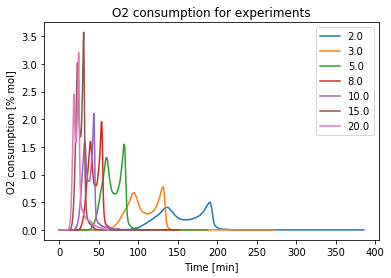

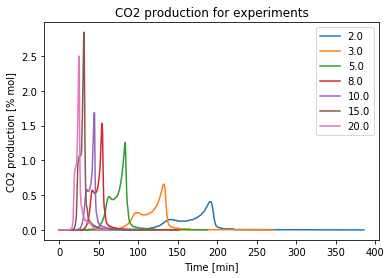

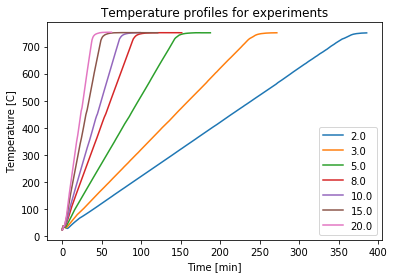

[0.30137999486165745, 0.53864656210615, 0.08908885574816416, 0.7426125585093104]


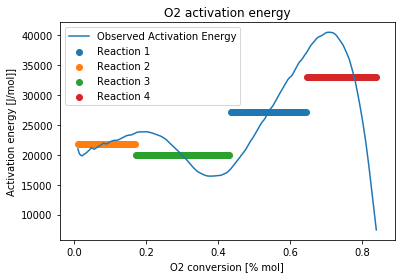

In [36]:
chichimene0PSI = RtoData('chichimene0PSI')
chichimene0PSI.print_consumption_curves()
# chichimene0PSI.print_isoconversional_curves(corrected=True)
chichimene0PSI.print_isoconversional_overlay(num_rxns=4, save_path=os.path.join('results','data_loading_tests'))

Loading heating rate 10.0...
Loading heating rate 15.0...
Loading heating rate 2.0...
Loading heating rate 20.0...
Loading heating rate 3.0...
Loading heating rate 5.0...
[0.03650467533395374, 0.21420647586841637, 0.12083773321471565]


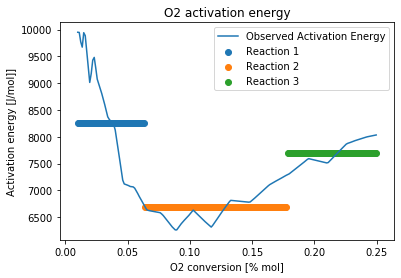

In [32]:
xinjiang0PSI = RtoData('xinjiang0PSI')
xinjiang0PSI.print_isoconversional_overlay(num_rxns=3)